In [10]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

In [53]:
def adjust_data(df, window):

    df['length'] = df['length'].astype(int)
    df['time'] = df['time'].astype(float)
    df['ip_dst'] = df['ip_dst'].astype(str)
    df['ip_src'] = df['ip_src'].astype(str)
    df['protocol'] = df['protocol'].astype(str)
    
    df['time_interval'] = (df['time'] // window)
    
    grouped = df.groupby('time_interval')
    
    # Creating the new dataframe with the specified features
    
    new_df = grouped['length'].agg(
        avg_length='mean',
        var_length='var',
        min_length='min',
        max_length='max',
        count_rows='size'
    )
    
    new_df
    # Calculating unique counts for ip_src, ip_dst, and their pairs
    
    new_df['unique_ip_src'] = grouped['ip_src'].nunique()
    
    new_df['unique_ip_dst'] = grouped['ip_dst'].nunique()
    
    new_df['unique_ip_src_dst'] = grouped.apply(lambda x: len(x[['ip_src', 'ip_dst']].drop_duplicates()))
    
     
    # Calculating ratios
    
    new_df['rows_per_unique_ip_src'] = new_df['count_rows'] / new_df['unique_ip_src']
    
    new_df['rows_per_unique_ip_dst'] = new_df['count_rows'] / new_df['unique_ip_dst']
    
    new_df['rows_per_unique_ip_src_dst'] = new_df['count_rows'] / new_df['unique_ip_src_dst']
    
    
    # Function to calculate entropy
    def calculate_entropy(series):
        value_counts = series.value_counts()
        probabilities = value_counts / len(series)
        return entropy(probabilities)
    
    # Adding entropy calculations for source and destination IPs
    new_df['entropy_ip_src'] = grouped['ip_src'].apply(calculate_entropy)
    new_df['entropy_ip_dst'] = grouped['ip_dst'].apply(calculate_entropy)
    
    new_df['repeated_connections'] = grouped.apply(lambda x: x.duplicated(subset=['ip_src', 'ip_dst']).sum())
    
    
    # Handling division by zero
    
    new_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    new_df.fillna(0, inplace=True)
    
    
     
    
    # Calculating the percentage of each protocol in each interval
    
    protocols = df['protocol'].unique()
    
    for protocol in protocols:
    
        protocol_column = f'percent_{protocol}'
    
        new_df[protocol_column] = grouped.apply(lambda x: (x['protocol'] == protocol).sum() / x.shape[0])
    
     
    
    new_df.reset_index(inplace=True)
    return new_df

In [35]:
ddos = pd.read_csv('DDOS.csv')
ddos.set_index('Unnamed: 0', inplace=True)
ddos

,time,ip_dst,ip_src,length,protocol
Unnamed: 0,,,,,
0,0.000000e+00,192.168.137.206,192.168.137.150,60,UDP
1,6.482500e-02,192.168.137.175,52.48.53.214,2482,TCP
2,6.482700e-02,192.168.137.175,52.48.53.214,100,TCP
3,7.956600e-02,192.168.137.2,35.185.101.66,66,TCP
4,8.622800e-02,192.168.137.206,192.168.137.150,60,UDP
...,...,...,...,...,...
2879829,4.687140e+06,192.168.137.20,192.168.137.150,74,TCP
2879830,4.687140e+06,192.168.137.17,192.168.137.150,74,TCP
2879831,4.687140e+06,192.168.137.186,192.168.137.150,74,TCP


In [36]:
benign = pd.read_csv("BenignTraffic.csv")
benign.set_index('Unnamed: 0', inplace=True)
benign

,time,ip_dst,ip_src,length,protocol
Unnamed: 0,,,,,
0,0.000000,99.81.244.93,192.168.137.175,2962,TCP
1,0.000164,99.81.244.93,192.168.137.175,2962,TCP
2,0.000269,99.81.244.93,192.168.137.175,1514,TCP
3,0.000414,99.81.244.93,192.168.137.175,1514,TCP
4,0.001800,99.81.244.93,192.168.137.175,1514,TCP
...,...,...,...,...,...
3644531,33327.964738,255.255.255.255,192.168.137.82,214,UDP
3644532,33327.967599,192.168.137.253,23.78.206.51,2962,TCP
3644533,33327.967997,192.168.137.253,23.78.206.51,4410,TCP


In [43]:
inject = pd.read_csv("CommandInjection.csv")
inject.set_index('Unnamed: 0', inplace=True)
inject

,time,ip_dst,ip_src,length,protocol
Unnamed: 0,,,,,
1,0.000000,192.168.137.163,47.254.83.84,74,TCP
2,0.088743,192.168.137.163,47.254.83.84,66,TCP
3,0.089114,192.168.137.163,47.254.83.84,66,TCP
4,0.119246,192.168.137.163,47.254.83.84,60,UDP
6,0.385753,192.168.137.219,47.88.56.147,60,TCP
...,...,...,...,...,...
55043,2339.894180,192.168.137.1,192.168.137.163,98,ICMP
55044,2340.014434,255.255.255.255,192.168.137.123,214,UDP
55045,2340.065338,192.168.137.1,192.168.137.242,110,ICMP


In [54]:
ddos_adjusted = adjust_data(ddos, 5)
ddos_adjusted['Class'] = 1
ddos_adjusted

,time_interval,avg_length,var_length,min_length,max_length,count_rows,unique_ip_src,unique_ip_dst,unique_ip_src_dst,rows_per_unique_ip_src,rows_per_unique_ip_dst,rows_per_unique_ip_src_dst,entropy_ip_src,entropy_ip_dst,repeated_connections,percent_UDP,percent_TCP,percent_ICMP,Class
0,0.0,446.636583,493550.950502,60,7306,4565,57,34,72,80.087719,134.264706,63.402778,2.122806,0.988053,4493,0.042059,0.956627,0.001314,1
1,1.0,441.576400,455055.961425,60,2962,6034,69,50,102,87.449275,120.680000,59.156863,1.840858,0.726670,5932,0.011932,0.987239,0.000829,1
2,2.0,213.461435,170262.815176,60,2962,5225,61,50,91,85.655738,104.500000,57.417582,2.115520,0.955799,5134,0.009761,0.989474,0.000766,1
3,3.0,320.276911,336099.076051,60,2962,6345,82,70,123,77.378049,90.642857,51.585366,2.099015,1.090799,6222,0.010717,0.988968,0.000315,1
4,4.0,440.391181,430906.890101,60,5858,4241,70,55,106,60.585714,77.109091,40.009434,1.597893,1.343256,4135,0.021929,0.977364,0.000707,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140,937424.0,136.052239,149067.979140,60,15774,2814,33,29,58,85.272727,97.034483,48.517241,0.322383,2.114859,2756,0.019900,0.979744,0.000355,1
1141,937425.0,111.924249,11457.425867,60,1487,2165,38,36,62,56.973684,60.138889,34.919355,0.279560,2.051427,2103,0.018476,0.980600,0.000924,1
1142,937426.0,104.437385,9786.030354,60,1474,2707,30,31,54,90.233333,87.322581,50.129630,0.234974,2.013531,2653,0.013299,0.985593,0.001108,1
1143,937427.0,105.299748,9265.266686,60,790,2382,33,30,54,72.181818,79.400000,44.111111,0.201990,2.029118,2328,0.013014,0.986566,0.000420,1


In [55]:
benign_adjusted = adjust_data(benign, 5)
benign_adjusted['Class'] = 0
benign_adjusted

,time_interval,avg_length,var_length,min_length,max_length,count_rows,unique_ip_src,unique_ip_dst,unique_ip_src_dst,rows_per_unique_ip_src,rows_per_unique_ip_dst,rows_per_unique_ip_src_dst,entropy_ip_src,entropy_ip_dst,repeated_connections,percent_TCP,percent_UDP,percent_ICMP,Class
0,0.0,569.061516,9.761190e+05,60,8754,699,65,55,112,10.753846,12.709091,6.241071,2.690884,2.661448,587,0.752504,0.216023,0.031474,0
1,1.0,534.213650,6.073021e+05,60,7791,674,58,44,81,11.620690,15.318182,8.320988,2.561900,2.474491,593,0.854599,0.136499,0.008902,0
2,2.0,671.580316,5.720322e+05,60,4410,1077,58,48,85,18.568966,22.437500,12.670588,2.433629,2.378519,992,0.927577,0.066852,0.005571,0
3,3.0,600.027066,1.089716e+06,60,10202,702,53,37,68,13.245283,18.972973,10.323529,2.357291,2.287758,634,0.841880,0.146724,0.011396,0
4,4.0,582.752053,9.781522e+05,60,11650,609,57,50,84,10.684211,12.180000,7.250000,2.435547,2.374926,525,0.868637,0.116585,0.014778,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6661,6661.0,814.809961,1.373199e+06,60,13098,763,62,51,84,12.306452,14.960784,9.083333,2.030041,1.972895,679,0.937090,0.060288,0.002621,0
6662,6662.0,492.996988,1.151472e+06,60,10202,332,54,40,65,6.148148,8.300000,5.107692,2.688147,2.550740,267,0.864458,0.135542,0.000000,0
6663,6663.0,703.522541,1.154508e+06,60,11650,488,55,40,69,8.872727,12.200000,7.072464,2.335044,2.227144,419,0.821721,0.172131,0.006148,0
6664,6664.0,878.558621,1.388055e+06,60,15031,870,53,36,64,16.415094,24.166667,13.593750,1.602473,1.532754,806,0.932184,0.067816,0.000000,0


In [59]:
inject_adjusted = adjust_data(inject, 5)
inject_adjusted['Class'] = 1
inject_adjusted

,time_interval,avg_length,var_length,min_length,max_length,count_rows,unique_ip_src,unique_ip_dst,unique_ip_src_dst,rows_per_unique_ip_src,rows_per_unique_ip_dst,rows_per_unique_ip_src_dst,entropy_ip_src,entropy_ip_dst,repeated_connections,percent_TCP,percent_UDP,percent_ICMP,Class
0,0.0,137.366337,9812.694455,60,583,101,43,31,56,2.348837,3.258065,1.803571,3.444762,3.101399,45,0.544554,0.396040,0.059406,1
1,1.0,124.657407,5943.610505,60,411,108,55,45,71,1.963636,2.400000,1.521127,3.704973,3.376451,37,0.564815,0.398148,0.037037,1
2,2.0,185.770833,120450.915351,60,2974,96,52,38,66,1.846154,2.526316,1.454545,3.672644,3.144699,30,0.520833,0.437500,0.041667,1
3,3.0,134.801527,10865.360305,60,811,131,52,42,75,2.519231,3.119048,1.746667,3.604985,3.266569,56,0.488550,0.412214,0.099237,1
4,4.0,182.194286,59124.088473,60,1514,175,49,44,83,3.571429,3.977273,2.108434,3.544774,3.227487,92,0.582857,0.314286,0.102857,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,464.0,180.246914,101276.137413,60,2288,162,57,42,77,2.842105,3.857143,2.103896,3.408092,3.134599,85,0.506173,0.407407,0.086420,1
237,465.0,133.080460,10006.098102,60,824,87,47,32,58,1.851064,2.718750,1.500000,3.542380,2.979867,29,0.574713,0.367816,0.057471,1
238,466.0,194.519802,63679.126472,60,2229,202,59,46,86,3.423729,4.391304,2.348837,3.441020,3.241440,116,0.346535,0.608911,0.044554,1
239,467.0,138.141176,8318.453324,60,373,170,48,37,67,3.541667,4.594595,2.537313,3.324948,3.162575,103,0.376471,0.494118,0.129412,1


In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Concatenate the dataframes
combined_df = pd.concat([benign_adjusted, ddos_adjusted])
combined_df = pd.concat([combined_df, inject_adjusted])

# Split the data into features and target variable
X = combined_df.drop(['Class', 'time_interval'], axis=1)
y = combined_df['Class']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Training the Random Forest Classifier
rf_classifier.fit(X_train, y_train)

# Making predictions on the Test set
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
combined_df

Accuracy: 0.9834437086092715
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2010
           1       0.96      0.94      0.95       406

    accuracy                           0.98      2416
   macro avg       0.97      0.97      0.97      2416
weighted avg       0.98      0.98      0.98      2416



,time_interval,avg_length,var_length,min_length,max_length,count_rows,unique_ip_src,unique_ip_dst,unique_ip_src_dst,rows_per_unique_ip_src,rows_per_unique_ip_dst,rows_per_unique_ip_src_dst,entropy_ip_src,entropy_ip_dst,repeated_connections,percent_TCP,percent_UDP,percent_ICMP,Class
0,0.0,569.061516,9.761190e+05,60,8754,699,65,55,112,10.753846,12.709091,6.241071,2.690884,2.661448,587,0.752504,0.216023,0.031474,0
1,1.0,534.213650,6.073021e+05,60,7791,674,58,44,81,11.620690,15.318182,8.320988,2.561900,2.474491,593,0.854599,0.136499,0.008902,0
2,2.0,671.580316,5.720322e+05,60,4410,1077,58,48,85,18.568966,22.437500,12.670588,2.433629,2.378519,992,0.927577,0.066852,0.005571,0
3,3.0,600.027066,1.089716e+06,60,10202,702,53,37,68,13.245283,18.972973,10.323529,2.357291,2.287758,634,0.841880,0.146724,0.011396,0
4,4.0,582.752053,9.781522e+05,60,11650,609,57,50,84,10.684211,12.180000,7.250000,2.435547,2.374926,525,0.868637,0.116585,0.014778,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,464.0,180.246914,1.012761e+05,60,2288,162,57,42,77,2.842105,3.857143,2.103896,3.408092,3.134599,85,0.506173,0.407407,0.086420,1
237,465.0,133.080460,1.000610e+04,60,824,87,47,32,58,1.851064,2.718750,1.500000,3.542380,2.979867,29,0.574713,0.367816,0.057471,1
238,466.0,194.519802,6.367913e+04,60,2229,202,59,46,86,3.423729,4.391304,2.348837,3.441020,3.241440,116,0.346535,0.608911,0.044554,1
239,467.0,138.141176,8.318453e+03,60,373,170,48,37,67,3.541667,4.594595,2.537313,3.324948,3.162575,103,0.376471,0.494118,0.129412,1


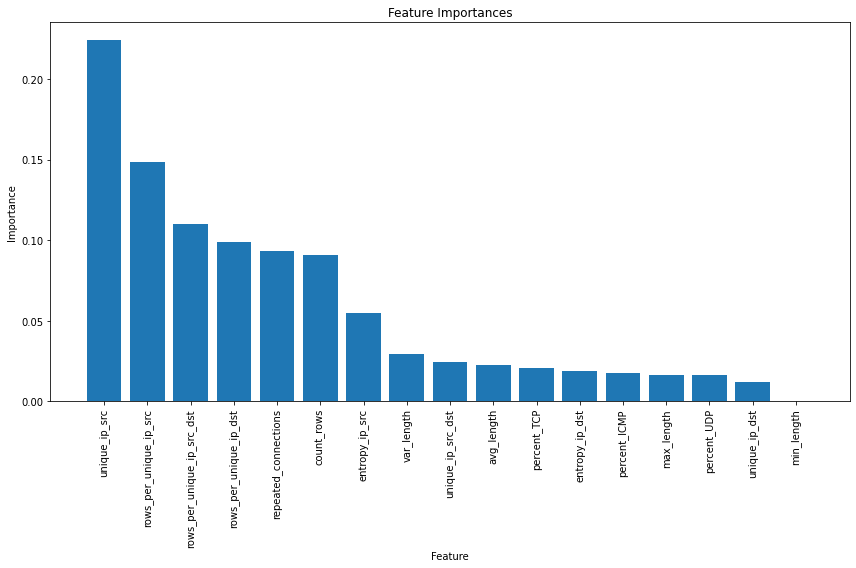

In [58]:
import matplotlib.pyplot as plt
feature_importances = rf_classifier.feature_importances_

# Getting feature names
feature_names = X_train.columns

# Sorting the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Creating a bar plot for feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

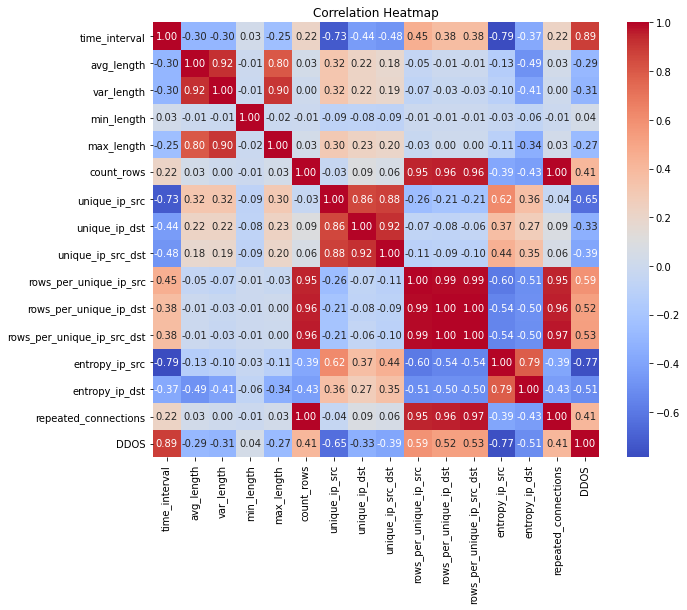

In [40]:
import seaborn as sns

# Compute the correlation matrix
corr = combined_df.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

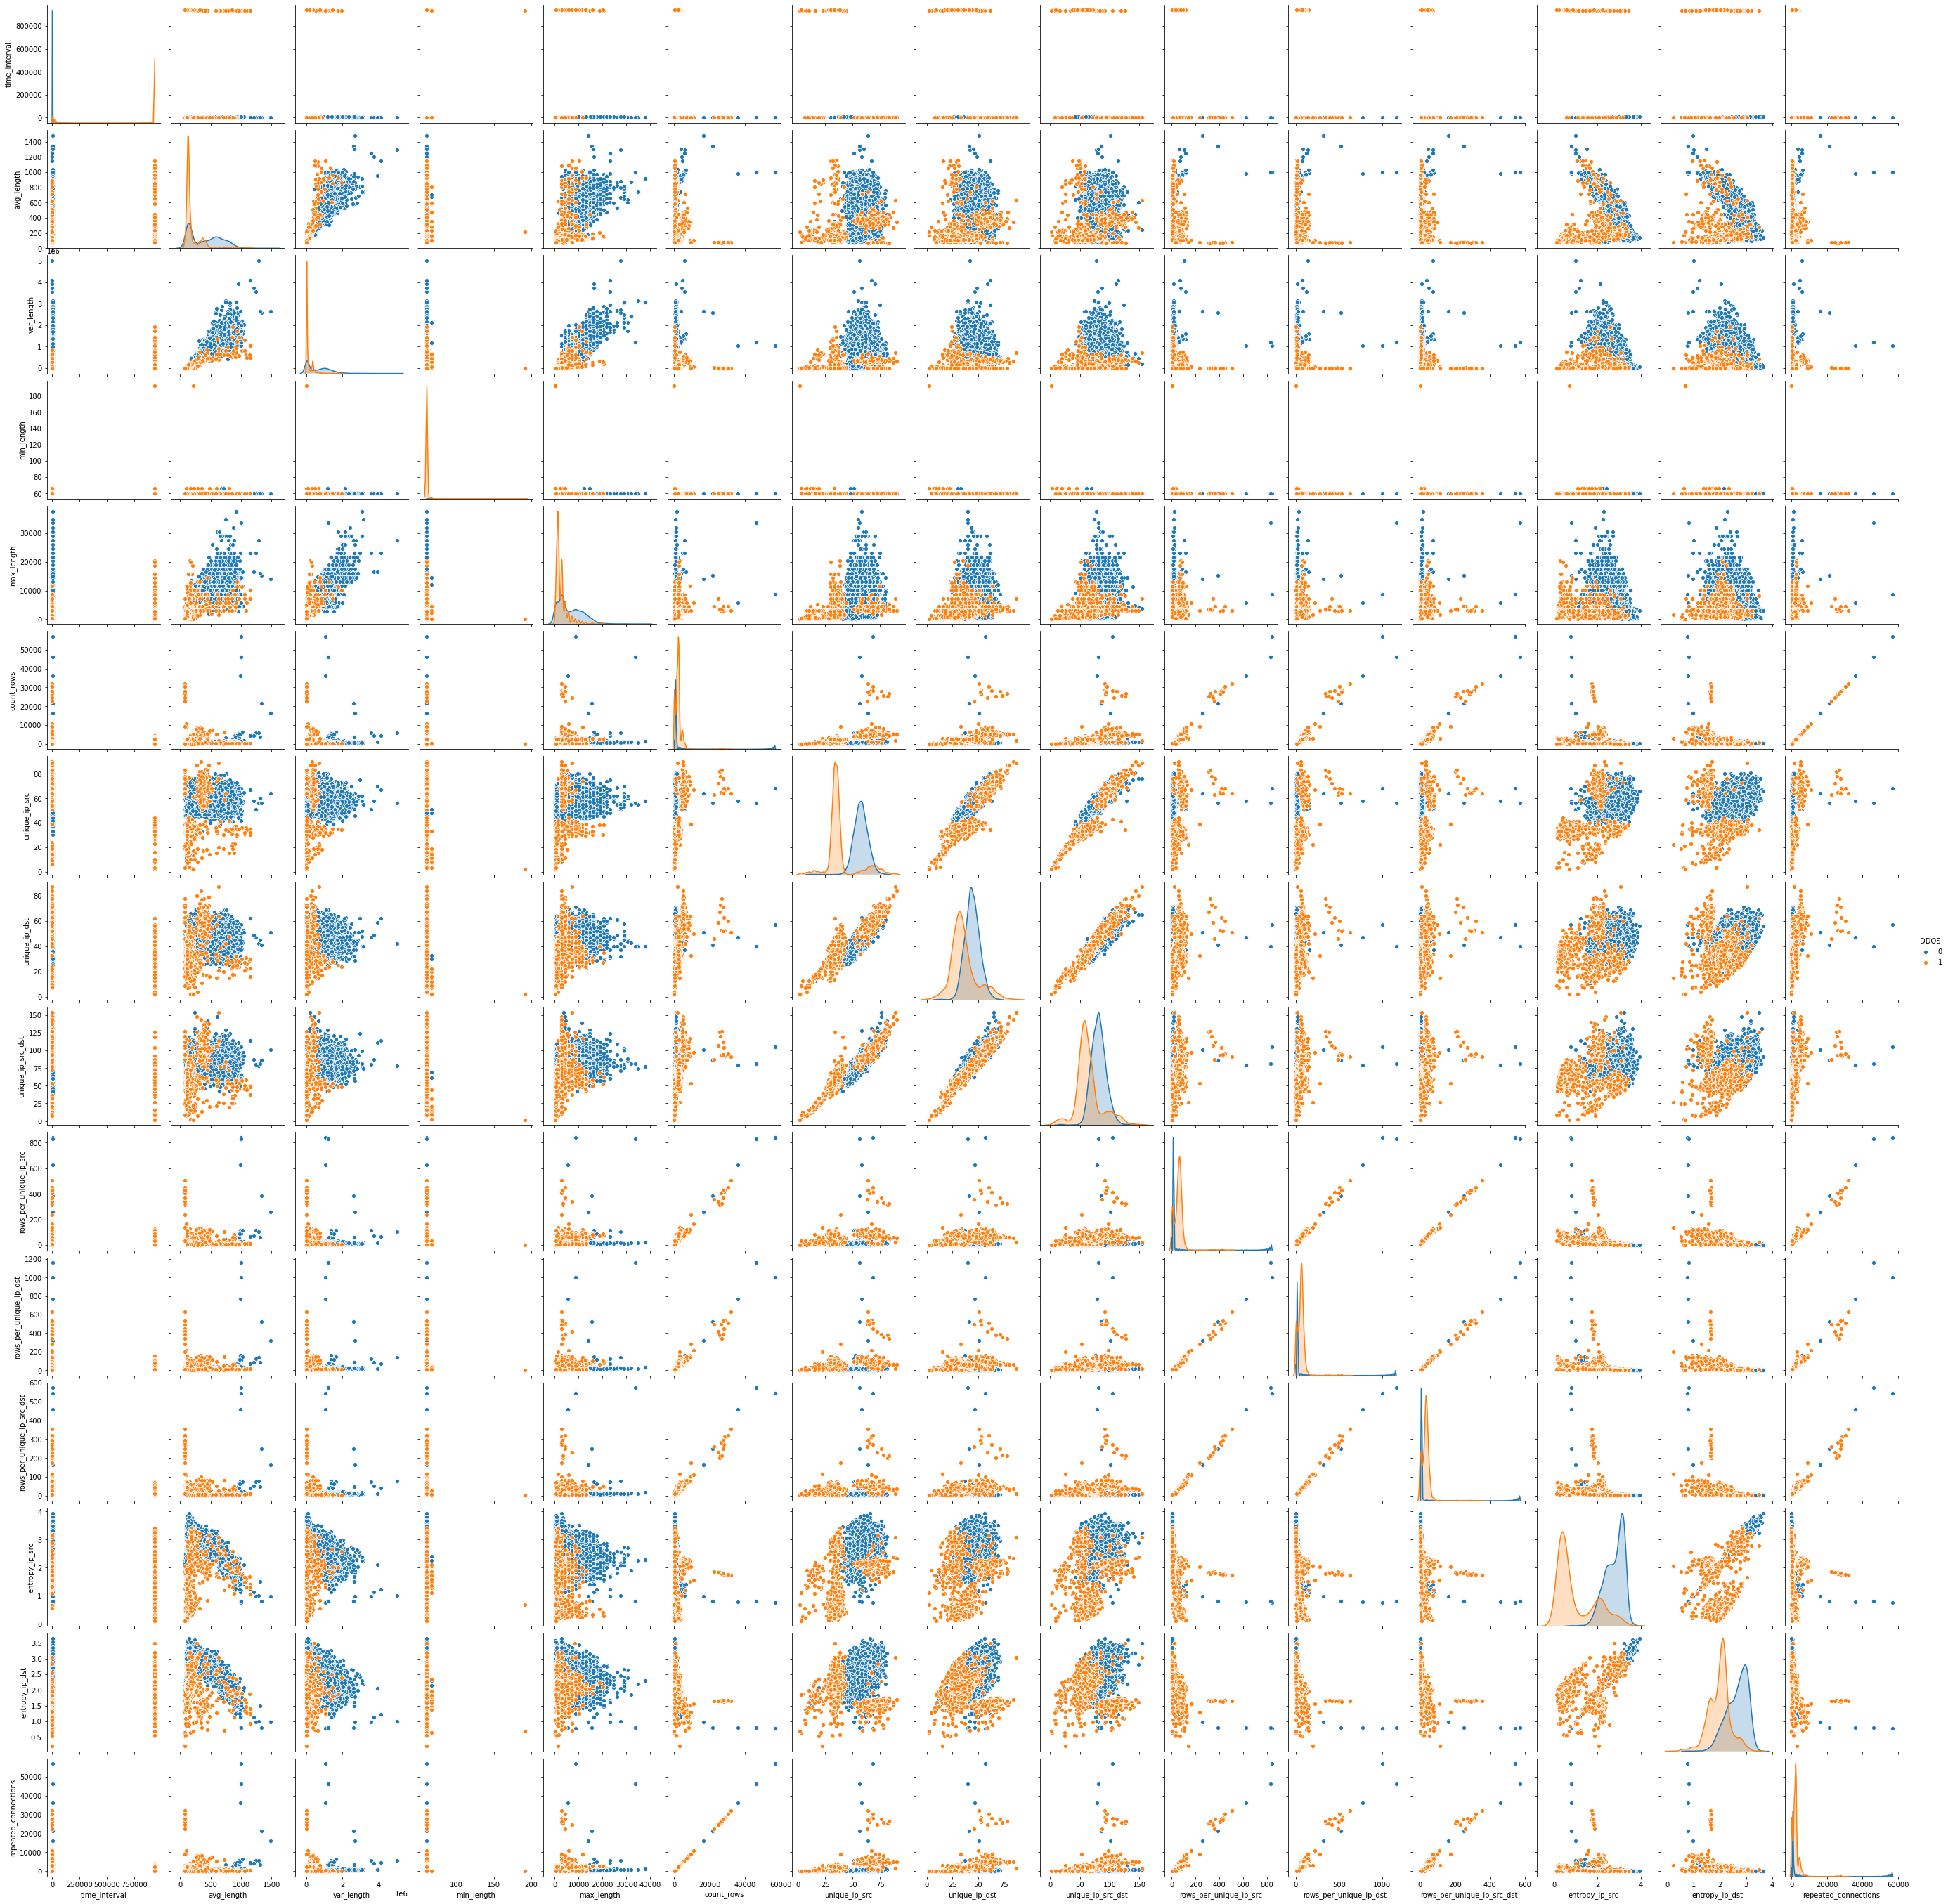

In [41]:
# Plotting pairwise relationships
sns.pairplot(combined_df, hue='DDOS', diag_kind='kde')
plt.show()

In [42]:
# Replace 'categorical_feature' with the name of the categorical feature
plt.figure(figsize=(8, 6))
sns.countplot(x='categorical_feature', data=combined_df)
plt.title("Count Plot of a Categorical Feature")
plt.show()

ValueError: Could not interpret input 'categorical_feature'

<Figure size 576x432 with 0 Axes>